In [1]:
import numpy as np
import time
import sys
from matplotlib import pyplot as plt
%matplotlib inline

## Gaussian streaming model ##

An example of how to run the Gaussian streaming model code to produce real- and redshift-space correlation functions (i.e. configuration-space 2-point functions).

The code needs an initial linear power spectrum:

In [2]:
# Read the linear theory power spectrum, produced by e.g. CAMB or CLASS.
# We scale the z = 0 power spectrum given to give z = 0.8 results to
# match those in the paper (Chen, Vlah & White 2020):
z, D, f   = 0.8, 0.6819, 0.8076
klin,plin = np.loadtxt('pk.dat',unpack=True)
plin     *= D**2

Now we import and initialize the class -- this takes a little while, but is a "one time" cost:

In [3]:
from LPT.gaussian_streaming_model_fftw import GaussianStreamingModel
# Let's time this, since the setup takes some time (a few seconds).
start = time.time()
#
gsm = GaussianStreamingModel(klin, plin)
gsm.convert_sigma_bases()
#
print("Elapsed time: ",time.time()-start," sec.")

Elapsed time:  3.0708510875701904  sec.


The first step is to compute the real-space correlation function and velocity statistics that go into the Gaussian Streaming Model.  We specify the bias parameters and call `compute_cumulants`.  This is very fast.

The parameters are
```
b1, b2, bs, b3, alpha, alpha_v, alpha_s0, alpha_s2, s2FoG
```
consisting of 4 bias parameters $(b1,b2,bs,b3)$, four counterterms and
a single stochastic term, s2FoG, which corrects for the zero-lag
value of the velocity dispersion.  Of these terms alpha_s0 and alpha_s2
are degenerate with other terms and so while we have included them in the
function signature we recommend that they be set to zero.

In [4]:
# Compute Velocity Statistcs in Configuration Space
# Here the parameters are:
#   b1, b2, bs, b3, alpha, alpha_v, alpha_s0, alpha_s2, s2FoG
#
bias = [1,-0.5,0.3,0.0]
cterm= [0, 0.0,0.0,0.0]
stoch= [0.0]
pars = bias + cterm + stoch
#
gsm.compute_cumulants(*pars)

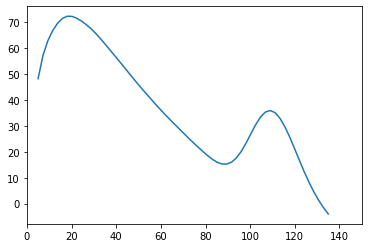

In [5]:
# Let's look at the real-space correlation function,
# this is also close to instantaneous:
#
rr  = np.linspace(5.0,135,61)
xir = gsm.compute_xi_real(rr,*pars)
#
plt.plot(rr, rr**2 * xir)
plt.xlim(0,150)
plt.show()

In [6]:
# Now integrate to get the correlation function multipoles:
# Note that if compute_cumulants has not previously been called,
# or called with a different set of pars, the call to compute_xi_ell
# (or xi_rsd) will automatically run it again.
#
# This routine can also handle AP parameters, here we set them
# to be 5% off the fiducial cosmology for illustration.
#
ss   = np.linspace(5,135,61)
xi0s = np.zeros_like(ss)
xi2s = np.zeros_like(ss)
#
start = time.time()
for ii, rr in enumerate(ss):
    xi0,xi2,xi4 = gsm.compute_xi_ell(rr,f,*pars,apar=1.05,aperp=1.05)
    xi0s[ii]    = xi0
    xi2s[ii]    = xi2
#
print("Elapsed time: ",time.time()-start," sec.")

Elapsed time:  0.3295605182647705  sec.


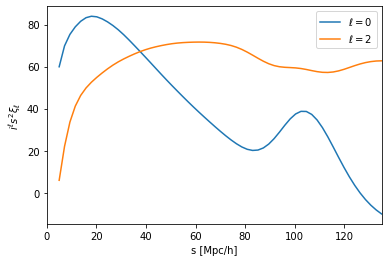

In [7]:
# Plot the results!
plt.plot(ss, ss**2 * xi0s, label=r'$\ell = 0$')
plt.plot(ss,-ss**2 * xi2s, label=r'$\ell = 2$')
#
plt.xlim(0,135)
#
plt.legend()
plt.xlabel('s [Mpc/h]')
plt.ylabel(r'$ i^\ell s^2 \xi_\ell$')
#
plt.show()

As part of the redshift-space calculation we also have the velocity statistics already computed.  As an example, let's look at the pairwise velocity:

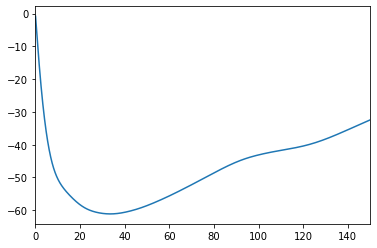

In [8]:
# Plot the dipole of the mean pairwise velocity:
plt.plot(gsm.rint, gsm.rint * gsm.veft)
plt.xlim(0,150)
plt.show()